# Линейная регрессия

**Выполнил студент ФИО**

Решение задачи регрессии в scikit-learn с помощью линейной модели - линейная регрессия

- Обучение класса SGDRegressor и анализ атрибутов
- Анализ модели для разных данных
- Предобразование целевой переменной с помощью класса TransformedTargetRegressor
- Сохранение модели

## Установка и импорт библиотек

In [1]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install plotly
%pip install seaborn
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import plotly.graph_objects as go # Библиотека Plotly. Модуль "Graph Objects"
import plotly.express as px # Библиотека Plotly. Модуль "Express"

# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler# Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder# Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder# Импортируем Порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

from sklearn.compose import TransformedTargetRegressor # ддля обрабоки целевой переменной

import warnings
warnings.filterwarnings('ignore')

# Описание датасета

'Laptop': Уникальный идентификатор или название модели ноутбука.

'Status': Новый или бывший в ремонте

'Brand': Производитель ноутбука

'Model': Модель ноутбука

'CPU' (центральный процессор): Марка, модель процессора и другие важные сведения

'GPU' (графический процессор): Марка, модель видеокарты и связанные с ней технические характеристики

'RAM' (оперативная память): Объем памяти

'Storage':  Емкость накопителя

'Storage type': Тип накопителя

'Screen': Диагональ экрана в дюймах

'Touch': Есть или нет тачскрин

'Final Price': Стоимость ноутбука в соответствующей валюте

Ссылка на датасет: https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset

In [6]:
df = pd.read_csv('car_crashes.csv')  # Считываем файл в DataFrame
df.head(5)  # Посмотрим первые пять записей

,Year,Month,Day,Weekend?,Hour,Collision Type,Injury Type,Primary Factor,Reported_Location,Latitude,Longitude
0,2015,1,5,Weekday,0.0,2-Car,No injury/unknown,OTHER (DRIVER) - EXPLAIN IN NARRATIVE,1ST & FESS,39.159207,-86.525874
1,2015,1,6,Weekday,1500.0,2-Car,No injury/unknown,FOLLOWING TOO CLOSELY,2ND & COLLEGE,39.161440,-86.534848
2,2015,1,6,Weekend,2300.0,2-Car,Non-incapacitating,DISREGARD SIGNAL/REG SIGN,BASSWOOD & BLOOMFIELD,39.149780,-86.568890
3,2015,1,7,Weekend,900.0,2-Car,Non-incapacitating,FAILURE TO YIELD RIGHT OF WAY,GATES & JACOBS,39.165655,-86.575956
4,2015,1,7,Weekend,1100.0,2-Car,No injury/unknown,FAILURE TO YIELD RIGHT OF WAY,W 3RD,39.164848,-86.579625


In [9]:
df['Weekend?'].fillna('Weekday', inplace = True)  # Заменим пропуски на самое часто встречающее значение - eng
df = df.dropna(subset=['Primary Factor'])
df = df.dropna(subset=['Latitude', 'Longitude', 'Hour', 'Reported_Location', 'Collision Type'])
df.info()  # Теперь пропущенных значений нет

<class 'pandas.core.frame.DataFrame'>
Index: 52582 entries, 0 to 53942
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               52582 non-null  int64  
 1   Month              52582 non-null  int64  
 2   Day                52582 non-null  int64  
 3   Weekend?           52582 non-null  object 
 4   Hour               52582 non-null  float64
 5   Collision Type     52582 non-null  object 
 6   Injury Type        52582 non-null  object 
 7   Primary Factor     52582 non-null  object 
 8   Reported_Location  52582 non-null  object 
 9   Latitude           52582 non-null  float64
 10  Longitude          52582 non-null  float64
dtypes: float64(3), int64(3), object(5)
memory usage: 4.8+ MB


## Числовые и категориальные признаки

Из предварительной обработки исключена колонка Final Price (поскольку она является целевой переменной и будет обработана отдельно)
и колонка Laptop (поскольку она дублирует другие колонки)

In [10]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [11]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

In [12]:
# Pipeline для числовых признаков

num_pipe_num = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('norm', MinMaxScaler())
])
 
num = ['Year', 'Month', 'Day', 'Hour', 'Latitude', 'Longitude']

# И для категориальных признаков

cat_pipe_Status_Touch = Pipeline([
    ('encoder', OrdinalEncoder())
])


cat_Status_Touch = ['Weekend?']

cat_pipe = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

cat = ['Weekend?', 'Collision Type', 'Injury Type', 'Primary Factor', 'Reported_Location']


# Сделаем отдельно Pipeline с числовыми признаками
preprocessors_num = ColumnTransformer(transformers=[
    ('num', num_pipe_num, num),
])


# И полный Pipeline со всеми признаками
preprocessors_All = ColumnTransformer(transformers=[
    ('norm', num_pipe_num, num),
    ('Status_Touch', cat_pipe_Status_Touch, cat_Status_Touch),
    ('cat', cat_pipe, cat)
])

In [13]:
columns_num = np.hstack([num])

# Линейная Регрессия

In [14]:
from sklearn.linear_model import SGDRegressor # Линейная регрессия с градиентным спуском от scikit-learn

from sklearn.model_selection import train_test_split  # Функция разбиения на тренировочную и тестовую выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit  # При кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate  # Функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse  # Метрика MSE от Scikit-learn
from sklearn.metrics import r2_score  # Коэффициент детерминации R2 от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay  # Класс визуализации ошибок модели

In [12]:
# Не забываем удалить целевую переменную цену из признаков
X,y = df.drop(columns = ['Final Price']), df['Final Price']

# Разбиваем датасет на обучающую и валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [13]:
X_train  # Посмотрим содержимое обучающей выборки

,Status,Brand,Model,CPU,RAM,Storage,Storage type,Screen,Touch
1250,New,Asus,TUF,Intel Core i7,16,512,SSD,15.6,No
2087,Refurbished,MSI,Prestige,Intel Core i7,16,512,SSD,14.0,No
310,New,Apple,MacBook Air,Apple M1,16,256,SSD,13.3,No
1423,New,HP,255,AMD Ryzen 5,8,256,SSD,15.6,No
1735,Refurbished,Apple,MacBook Air,Intel Core i5,8,128,SSD,13.3,No
...,...,...,...,...,...,...,...,...,...
1642,New,Microsoft,Surface Laptop,Intel Core i7,16,512,SSD,14.4,Yes
1096,New,Acer,Extensa,Intel Core i5,8,256,SSD,15.6,No
1131,Refurbished,Apple,Macbook,Intel Core M3,8,256,SSD,12.0,No
1295,New,Acer,TravelMate,Intel Core i5,16,512,SSD,14.0,No


# Оценим модель с использованием только числовых признаков

In [14]:
#  На тренировочных данных делаем fit_transform - одновременно и обучаемся, и преобразуем тренировочные данные
X_train_prep = preprocessors_num.fit_transform(X_train)
# После на валидационных данных делаем уже только transform - преобразуем данные согласно ранее запомненным параметрам, полученным на тренировочной выборке
X_val_prep = preprocessors_num.transform(X_val)

### Обучаем модель

In [15]:
model = SGDRegressor(random_state = 42)  # Суть параметра random_state (во всех функциях и методах из SciKit-Learn) в воспроизводимых случайных значениях. 
                                         # Т.е. если явно задать значение random_state отличным от None - то генерируемые псевдослучайные величины будут иметь 
                                         # одни и те же значения при каждом вызове.

model.fit(X_train_prep, y_train);  # Обучаем модель на тренировочной выборке

## Подготовим несколько функций для анализа обученной модели

Извлечение коэффициентов из модели

In [16]:
def get_coefs(model):  # model: наша обученная модель

    B0 = model.intercept_[0]
    B = model.coef_
    return B0, B

In [17]:
def print_model (B0,B,features_names):
    """Написание уравнения модели.
    Входные переменные:
    ===========
    B0: смещение (независимый коэффициент)
    weights: веса признаков
    features_names: список названий признаков
    """
    line='{:.3f}'.format(B0)
    sign=['+','-']
    for p,(fn,b) in enumerate(zip(features_names,B)):
        line=line+sign[int(0.5*(np.sign(b)-1))]+'{:.2f}*'.format(np.abs(b))+fn

    print('Решение')
    print(line)

## Визуализации весов в виде столбчатых диаграмм

In [18]:
def vis_weigths(weights,features_names = None, width = 1200, height = 600):
    """Отрисовка весов.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    """
    numbers = np.arange(0,len(weights))                 # создаем массив от 0 до количество весов-1
    if features_names:
        tick_labels = np.hstack(['B0',features_names])
    else:
        tick_labels = ['B'+str(num) for num in numbers]  # создаем "названия" весов
    fig = go.Figure()
    fig.add_trace(go.Bar(x=numbers[weights<0], y=weights[weights<0],
                    marker_color='red',
                    name='отрицательные веса'))
    fig.add_trace(go.Bar(x=numbers[weights>=0], y=weights[weights>=0],
                    marker_color='blue',
                    name='положительные веса'
                    ))

    fig.update_layout(
                title="Веса модели",
                width=width,
                height=height,
                template = "plotly_dark",
                xaxis = dict(
                                         tickmode = 'array',
                                         tickvals = numbers,
                                         ticktext = tick_labels,
                                         )
                )

    fig.show()

### Напишем уравнение модели

In [19]:
B0, B = get_coefs(model)
features_names = list(columns_num)
print_model(B0,B,features_names)

Решение
404.572+2224.73*RAM+1994.78*Storage-132.11*Screen


### Визуализируем веса в виде столбчатых диаграмм

In [20]:
Bs = np.hstack([B0,B])
vis_weigths(Bs,features_names)

Видно, что признаки RAM и Storage в модели имеют наибольшие коэффициенты, следовательно, они больше влияют на целевой показатель - цену. Также признак Screen имеет отрицательный коэффициент - это означает, что ноутбуки с большей диагональю будут дешевле, что не очевидно.

### Оценка метрик

In [21]:
def calculate_metric(model_pipe, X, y, metric = r2_score, **kwargs):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model, **kwargs)

In [22]:
print(f"r2 на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(model, X_train_prep, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(model, X_val_prep, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.5738
r2 на валидационной выборке: 0.5930
mse на тренировочной выборке: 341896.1527
mse на валидационной выборке: 364746.6333
rmse на тренировочной выборке: 584.7189
rmse на валидационной выборке: 603.9426


## Кросс-валидация

In [23]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [24]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [25]:
cross_validation (X_train_prep, y_train,
                  model,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.010002,0.002000,0.652804,-305185.511113,-398.126929,-2233.176096
1,0.014002,0.002001,0.538735,-412271.524337,-410.775549,-4137.133622
2,0.012002,0.001001,0.528748,-572373.405266,-495.158613,-4152.702632
3,0.014002,0.001001,0.547257,-393035.564559,-441.906677,-2542.453222
4,0.010002,0.001001,0.628330,-270978.171534,-394.006707,-2238.911685




test_R2           0.579175
test_-MSE   -390768.835362
test_-MAE      -427.994895
test_-Max     -3060.875451
dtype: float64


### Визуализация ошибок от scikit-learn

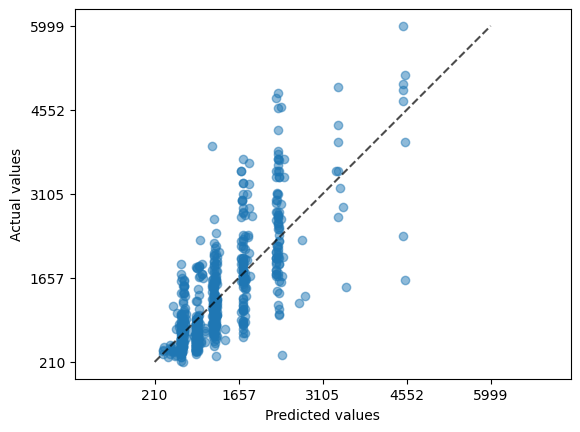

In [26]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Небольшие выводы по модели:

* Используя только 3 числовых признака можно с достаточно большой погрешностью предсказывать цены

* Результаты сильно кластеризуются - сказывается влияние ограниченного числа значений у числовых признаков

* Больше проблем при предсказании высоких цен

* Увеличение объема памяти и оперативной памяти положительно сказывается на цене, размер экрана - отрицательно



## Объединяем Pipeline Предобработки и Модель

In [27]:
pipe_num = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', SGDRegressor(random_state = 42))
])

In [28]:
pipe_num['model']

SGDRegressor(random_state=42)

In [29]:
pipe_num.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('norm',
                                                                   MinMaxScaler())]),
                                                  ['RAM', 'Storage',
                                                   'Screen'])])),
                ('model', SGDRegressor(random_state=42))])

In [30]:
B0, B = get_coefs(pipe_num['model'])
features_names = list(columns_num)

print_model (B0,B,features_names)

Решение
404.572+2224.73*RAM+1994.78*Storage-132.11*Screen


In [31]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(pipe_num, X_train, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(pipe_num, X_val, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.5738
r2 на валидационной выборке: 0.5930
mse на тренировочной выборке: 341896.1527
mse на валидационной выборке: 364746.6333
rmse на тренировочной выборке: 584.7189
rmse на валидационной выборке: 603.9426


In [32]:
cross_validation (X_train, y_train,
                  pipe_num,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.017003,0.004000,0.656269,-302139.792320,-396.557661,-2273.058674
1,0.015003,0.005001,0.540885,-410350.018294,-410.967016,-4095.426421
2,0.018005,0.003000,0.526215,-575450.574983,-497.257098,-4155.360639
3,0.019004,0.003001,0.546919,-393329.370772,-442.323456,-2535.346377
4,0.015003,0.004001,0.632660,-267821.301988,-386.410758,-2269.259791




test_R2           0.580590
test_-MSE   -389818.211671
test_-MAE      -426.703198
test_-Max     -3065.690380
dtype: float64


## Оценим влияние предварительной обработки целевой переменной

In [33]:
pipe_num_transform = Pipeline([
    ('preprocessors', preprocessors_num),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

In [34]:
pipe_num_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('norm',
                                                                   MinMaxScaler())]),
                                                  ['RAM', 'Storage',
                                                   'Screen'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

In [35]:
B0, B = get_coefs(pipe_num_transform['model'].regressor_)
features_names = list(columns_num)

print_model (B0,B,features_names)

Решение
-0.858+1.97*RAM+2.03*Storage-0.11*Screen


In [36]:
Bs = np.hstack([B0,B])
vis_weigths(Bs,features_names)

Смещение (член нулевого порядка) стал отрицательным и сильно уменьшился по модулю, влияние RAM уступило влиянию Storage, остальные соотношения без критичных изменений.

In [37]:
cross_validation (X_train, y_train,
                  pipe_num_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.015004,0.005001,0.544146,-400695.890328,-418.493066,-2582.842139
1,0.013003,0.005001,0.441428,-499243.151275,-448.666580,-4326.505920
2,0.012003,0.004001,0.419190,-705441.351798,-522.156647,-4369.909419
3,0.013003,0.003001,0.416948,-506159.653661,-471.703045,-2699.036974
4,0.013003,0.004001,0.574037,-310562.377880,-366.888338,-3602.488114




test_R2           0.479150
test_-MSE   -484420.484989
test_-MAE      -445.581535
test_-Max     -3516.156513
dtype: float64


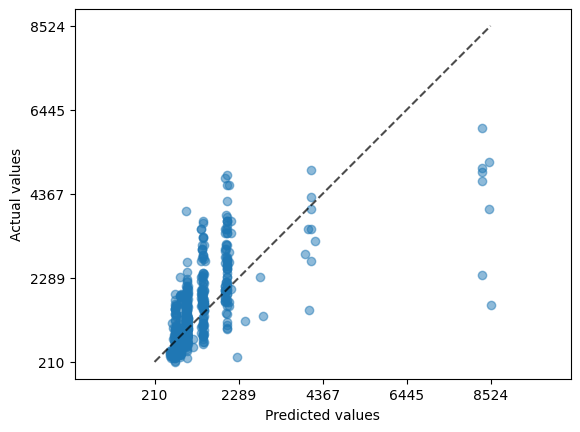

In [38]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_num_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Небольшие выводы по модели:

* Предварительная обработка целевой переменной в данном случае не улучшает результаты линейной модели (метрика r2 на кроссвалидации 0.47 против 0.58)

* В целом предварительная обработка целевой переменной сделала хуже предсказание высоких значений цен

* В области низких цен кластеризация несколько уменьшилась, но не ушла полностью (косвенно подтверждает гипотезу о влиянии ограниченного набора значений числовых признаков)



# Оценим влияние категориальных признаков

In [39]:
pipe_all_transform = Pipeline([
    ('preprocessors', preprocessors_All),
    ('model', TransformedTargetRegressor( regressor=SGDRegressor(random_state = 42),
    transformer=PowerTransformer())
    )
])

In [40]:
pipe_all_transform.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('norm',
                                                  Pipeline(steps=[('QuantReplace',
                                                                   QuantileReplacer(threshold=0.01)),
                                                                  ('norm',
                                                                   MinMaxScaler())]),
                                                  ['RAM', 'Storage', 'Screen']),
                                                 ('Status_Touch',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Status', 'Touch']),
                                                 ('cat',
                                                  Pipeline(steps=[('replace_rare',
                                                                   RareGrouper(threshold=0.0001)),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Status', 'Touch', 'Brand',
                                                   'Model', 'CPU',
                                                   'Storage type'])])),
                ('model',
                 TransformedTargetRegressor(regressor=SGDRegressor(random_state=42),
                                            transformer=PowerTransformer()))])

In [41]:
cat_Status_Touch_names = pipe_all_transform['preprocessors'].transformers_[1][
    1]['encoder'].get_feature_names_out(cat_Status_Touch)
cat_names = pipe_all_transform['preprocessors'].transformers_[2][1][
    'encoder'].get_feature_names_out(cat)

# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([num, cat_Status_Touch, cat])

In [42]:
B0, B = get_coefs(pipe_all_transform['model'].regressor_)
features_names = list(columns)

print_model (B0,B,features_names)

Решение
-0.463+0.97*RAM+0.99*Storage+0.19*Screen-0.18*Status+0.20*Touch-0.18*Status+0.20*Touch-0.16*Brand-0.31*Model+0.31*CPU-0.19*Storage type


In [43]:
def vis_weigths_threshold(weights, feature_names, threshold, width = 1200, height = 600):
    """Отрисовка весов с фильтром.
    Входные переменные:
    ===========
    weights: веса признаков
    features_names: список названий признаков
    threshold: порог "значимости" коэффициентов
    """
    # фильтруем веса коэффициентов
    mask = np.abs(weights) >= threshold
    weights_filtered = weights[mask]
    feature_names_filtered = [name for name, m in zip(feature_names, mask[1:]) if m]

    # Рисуем столбчатую диаграмму
    vis_weigths(weights_filtered,feature_names_filtered, width = width, height = height)

In [44]:
Bs = np.hstack([B0,B])
vis_weigths_threshold(Bs,columns, 0.08, width = 1800)

In [45]:
cat_names  # Можно посмотреть, что скрывается за индексами

array(['Status_Refurbished', 'Touch_Yes', 'Brand_Acer', 'Brand_Alurin',
       'Brand_Apple', 'Brand_Asus', 'Brand_Deep Gaming', 'Brand_Dell',
       'Brand_Denver', 'Brand_Dynabook Toshiba', 'Brand_Gigabyte',
       'Brand_HP', 'Brand_Innjoo', 'Brand_Jetwing', 'Brand_LG',
       'Brand_Lenovo', 'Brand_MSI', 'Brand_Medion', 'Brand_Microsoft',
       'Brand_Millenium', 'Brand_PcCom', 'Brand_Primux', 'Brand_Prixton',
       'Brand_Razer', 'Brand_Realme', 'Brand_Samsung', 'Brand_Thomson',
       'Brand_Vant', 'Model_100e', 'Model_14w', 'Model_15S', 'Model_17',
       'Model_250', 'Model_255', 'Model_300w', 'Model_470', 'Model_A7',
       'Model_AZIR', 'Model_Aero', 'Model_Akoya', 'Model_Alpha',
       'Model_Alurin', 'Model_Aorus', 'Model_Aspire', 'Model_BR',
       'Model_Beast', 'Model_Blade', 'Model_Book', 'Model_Book Prime',
       'Model_Bravo', 'Model_Chromebook', 'Model_Classmate Pro',
       'Model_ConceptD', 'Model_Creator', 'Model_Crosshair',
       'Model_Deputy', 'Model_E410',

In [46]:
print(f"r2 на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val, mse):.4f}")

print(f"rmse на тренировочной выборке: {calculate_metric(pipe_all_transform, X_train, y_train, mse, squared = False):.4f}")
print(f"rmse на валидационной выборке: {calculate_metric(pipe_all_transform, X_val, y_val, mse, squared = False):.4f}")

r2 на тренировочной выборке: 0.7144
r2 на валидационной выборке: 0.7690
mse на тренировочной выборке: 229088.3842
mse на валидационной выборке: 206986.8320
rmse на тренировочной выборке: 478.6318
rmse на валидационной выборке: 454.9581


In [47]:
cross_validation (X_train, y_train,
                  pipe_all_transform,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 73))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,0.034007,0.008002,0.747168,-229196.276863,-297.084559,-3061.687218
1,0.032007,0.007783,0.760271,-128326.298884,-248.674765,-1660.500354
2,0.030007,0.008002,0.690057,-251497.163545,-319.213894,-2663.729026
3,0.038009,0.008002,0.729940,-220611.140148,-276.085028,-3800.919335
4,0.033007,0.007002,0.789465,-174383.838180,-255.272228,-3085.817301




test_R2           0.743380
test_-MSE   -200802.943524
test_-MAE      -279.266095
test_-Max     -2854.530647
dtype: float64


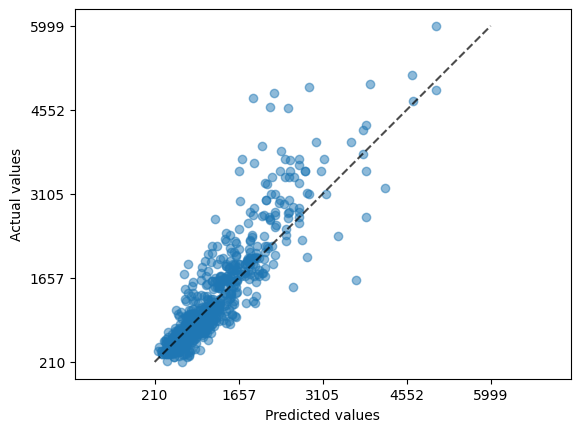

In [48]:
PredictionErrorDisplay.from_predictions(
    y_val,
    pipe_all_transform.predict(X_val),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
);

Выводы по модели:

* Добавление категориальных признаков улучшает результаты линейной модели (метрика r2 на кроссвалидации 0.74 против 0.58)

* Результаты так явно не кластеризуются

* Предсказание дорогих ноутбуков немного улучшилось, в предсказании средних по цене все еще проблема.

* Наиболее значимыми оказались числовые признаки: объем накопителя и оперативной памяти.

